In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from plot_params import *
out_stem = 'K562_rep6'
basedir = Path('/home/hsher/scratch/ABC_2rep/')
df = pd.read_csv(f'/home/hsher/scratch/ABC_2rep/DMM/{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)
df['name'] = df.index

out_stem1 = 'K562_rep4'
df1 = pd.read_csv(f'/home/hsher/scratch/ABC_2rep/DMM/{out_stem1}.megaoutputs.tsv', sep = '\t', index_col = 0)
df1['name'] = df1.index

out_stem2 = 'HEK293_rep1'
df2 = pd.read_csv(f'/home/hsher/scratch/ABC_2rep/DMM/{out_stem2}.megaoutputs.tsv', sep = '\t', index_col = 0)
df2['name'] = df2.index

out_stem3 = 'HEK293_rep2'
df3 = pd.read_csv(f'/home/hsher/scratch/ABC_2rep/DMM/{out_stem3}.megaoutputs.tsv', sep = '\t', index_col = 0)
df3['name'] = df3.index

mega_df = df.merge(df2.loc[:, df2.columns.str.contains('logLR:')], left_index = True, right_index = True
                  ).merge(df1.loc[:, df1.columns.str.contains('logLR:')], left_index = True, right_index = True
                ).merge(df3.loc[:, df3.columns.str.contains('logLR:')], left_index = True, right_index = True
                       )

In [2]:
mega_df.shape

(54792, 167)

# generate input for branchpointer

In [3]:
def find_branchpoint_region(intron_df):
    ''' find brancpoint region -18 to -44 from SS3_ADJ boundry for "branchpointer"
    
    (+)
    
    5'--//--start ---intron ----end--3SS --3'
    
    (-)
    5'--//--end ---intron ----start --3SS-- 3'
    see https://www.bioconductor.org/packages/devel/bioc/vignettes/branchpointer/inst/doc/branchpointer.pdf
    '''
    pos_df = intron_df.loc[intron_df['strand']=='+']
    neg_df = intron_df.loc[intron_df['strand']=='-']

    # positive strand
    pos_df['br_start'] = pos_df['end']-44
    pos_df['br_end'] = pos_df['end']-18

    # neg strand
    neg_df['br_start'] = neg_df['start']+18
    neg_df['br_end'] = neg_df['start']+44

    br_df = pd.concat([pos_df, neg_df], axis = 0)
    br_df = br_df[['chrom', 'br_start', 'br_end', 'name', 'score', 'strand']]
    br_df.columns = ['chrom', 'start', 'end','name', 'score', 'strand']

    return br_df

In [4]:
window_df = pd.read_csv('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz', sep = '\t')
br = find_branchpoint_region(window_df.loc[window_df['feature_type_top']=='SS3_ADJ'])

/scratch/hsher/33893438.tscc-mgr7.local/ipykernel_36693/2818328503.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['br_start'] = pos_df['end']-44
/scratch/hsher/33893438.tscc-mgr7.local/ipykernel_36693/2818328503.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['br_end'] = pos_df['end']-18
/scratch/hsher/33893438.tscc-mgr7.local/ipykernel_36693/2818328503.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [5]:
br[['name', 'chrom', 'start', 'end', 'strand']].to_csv('/home/hsher/scratch/K562_br_region.tsv', sep = '\t', index = False, header = False)

# Read branchpointer output

In [6]:
scores = pd.read_csv('/home/hsher/scratch/K562_br_score.tsv',
                     sep = ' ')

In [7]:
scores = scores.loc[scores['branchpoint_prob']>0.52]


In [8]:
from scipy.stats import pearsonr

PearsonRResult(statistic=0.14500024824797983, pvalue=9.691214452031846e-14)

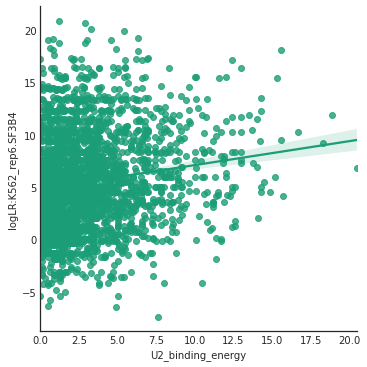

In [11]:
strongest_br = scores.groupby(by = 'id')[['branchpoint_prob', 'U2_binding_energy']].sum()
strongest_br[f'logLR:{out_stem}.SF3B4']=df[f'logLR:{out_stem}.SF3B4']
strongest_br.dropna(subset = [f'logLR:{out_stem}.SF3B4'], inplace = True)

sns.lmplot(data = strongest_br,x = 'U2_binding_energy', y = f'logLR:{out_stem}.SF3B4',
          )
pearsonr(strongest_br['U2_binding_energy'], strongest_br[f'logLR:{out_stem}.SF3B4'])

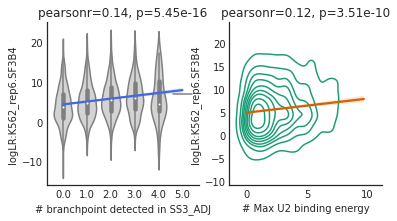

In [13]:
f, axes = plt.subplots(1,2,figsize = (6,3))

strongest_br = scores['id'].value_counts().to_frame()
strongest_br.columns = ['n branchpoint']
# strongest_br[f'logLR:{out_stem}.SF3B4']=df[f'logLR:{out_stem}.SF3B4']
# strongest_br.dropna(subset = [f'logLR:{out_stem}.SF3B4'], inplace = True)
strongest_br = strongest_br.merge(df.loc[df['feature_type_top']=='SS3_ADJ',[f'logLR:{out_stem}.SF3B4']], left_index = True, right_index = True, how = 'right')
strongest_br['n branchpoint'] = strongest_br['n branchpoint'].fillna(0)
sns.violinplot(data=strongest_br, x="n branchpoint", y="logLR:K562_rep6.SF3B4",
             marker = '.', alpha = 0.3, color = 'lightgrey', ax = axes[0])
# sns.stripplot(data=strongest_br, x="n branchpoint", y="logLR:K562_rep6.SF3B4",
#              marker = '.', alpha = 0.3, color = 'grey', ax = ax)
sns.regplot(data = strongest_br,x = 'n branchpoint', y = f'logLR:{out_stem}.SF3B4', 
           scatter = False, ax = axes[0], color = 'royalblue')

r,p=pearsonr(strongest_br['n branchpoint'], strongest_br[f'logLR:{out_stem}.SF3B4'])
axes[0].set_title(f'pearsonr={r:.2f}, p={p:.2e}')
axes[0].set_xlabel('# branchpoint detected in SS3_ADJ')
strongest_br = scores.groupby(by = 'id')[['branchpoint_prob', 'U2_binding_energy']].max()
strongest_br[f'logLR:{out_stem}.SF3B4']=df[f'logLR:{out_stem}.SF3B4']
strongest_br.dropna(subset = [f'logLR:{out_stem}.SF3B4'], inplace = True)

sns.kdeplot(data = strongest_br,x = 'U2_binding_energy', y = f'logLR:{out_stem}.SF3B4', ax = axes[1])
sns.regplot(data = strongest_br,x = 'U2_binding_energy', y = f'logLR:{out_stem}.SF3B4',
           scatter = False, ax = axes[1])
r,p=pearsonr(strongest_br['U2_binding_energy'], strongest_br[f'logLR:{out_stem}.SF3B4'])
axes[1].set_title(f'pearsonr={r:.2f}, p={p:.2e}')
axes[1].set_xlabel('# Max U2 binding energy')
sns.despine()

plt.savefig(figdir / 'n_br_SF3B4.pdf')
